## Lab Report 2A
#### LT5
Cua, Gavin<br>
Garcia, Andy<br>
Macaraeg, Pauline<br>
Zornosa, Dave

Note:<br>
PCA Code in lab2a_func.py<br>
MPT Code in mpt.py

In [2]:
import lab2a_func as l2af
import lab2a_func
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import importlib
importlib.reload(lab2a_func)


<module 'lab2a_func' from '/home/andy/Work/AIM/Subjects/Term 2/Data Mining And Wrangling/Lab2A/lab2a_func.py'>

In [3]:
import sys
!{sys.executable} -m pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


## Basic Goal

## Get the list of current S&P 500 companies

In [4]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())


  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


## Download the historical price data (Adj Close) and construct the design matrix

In [5]:
year = 2000
filename = f'spx_{year}_adj_close.csv'
startdate = datetime.datetime(year,1,1)
# From 2000 to 2020
df_spx = l2af.load_data(tickers, startdate, filename, days=20*365, force=False)
print(df_spx.shape)
df_spx.head()

(5028, 503)


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
2000-01-03 00:00:00,17.436209,2.330967,8.992849,NaN,NaN,16.274672,15.500,25.357716,6.878607,43.613007,...,11.427906,9.374685,NaN,NaN,6.977995,NaN,4.657411,25.027779,NaN,NaN
2000-01-04 00:00:00,16.743370,2.297380,8.735914,NaN,NaN,14.909399,14.625,24.352148,6.696075,40.281479,...,10.998601,9.166777,NaN,NaN,7.138669,NaN,4.563794,24.666668,NaN,NaN
2000-01-05 00:00:00,17.228352,2.290663,8.719851,NaN,NaN,15.204173,15.000,24.614468,6.657651,37.782799,...,11.581244,9.733794,NaN,NaN,7.414122,NaN,4.587198,25.138889,NaN,NaN
2000-01-06 00:00:00,18.614014,2.257075,9.024966,NaN,NaN,15.328290,16.000,24.811211,6.792147,36.344166,...,12.122990,9.941695,NaN,NaN,7.345258,NaN,4.548192,23.777779,NaN,NaN
2000-01-07 00:00:00,18.983524,2.351121,9.121316,NaN,NaN,16.072985,16.250,25.292133,6.926643,39.372849,...,11.724339,10.206312,NaN,NaN,7.345258,NaN,4.446774,23.513889,NaN,NaN


In [6]:

# Clean the data
df_spx = l2af.clean_data(df_spx)
print(df_spx.shape)
# df_spx


(5028, 355)


## Calculate for the returns matrix R and standardized returns Y

In [7]:

R, Y  = l2af.calculate_returns(df_spx)
# R.head()


## Construct the correlation matrix

In [8]:
filename_corr = f'correlation_matrix_{year}.csv'
p = l2af.consrtuct_correlation_matrix(Y, filename_corr, force=True)
# p.dropna(inplace=True)
p.head()

,0,1,2,3,4,5,6,7,8,9,...,345,346,347,348,349,350,351,352,353,354
0,1.000000,0.417241,0.371036,0.367749,0.275550,0.267296,0.454979,0.389132,0.555496,0.258293,...,0.331293,0.442974,0.364688,0.341597,0.265181,0.528308,0.285211,0.255303,0.401627,0.329680
1,0.417241,1.000000,0.251483,0.308117,0.286290,0.256469,0.381390,0.342662,0.419821,0.230506,...,0.246736,0.387334,0.346095,0.357184,0.271707,0.437830,0.248027,0.193304,0.329277,0.326880
2,0.371036,0.251483,1.000000,0.229366,0.168729,0.179862,0.298817,0.198120,0.354733,0.126530,...,0.313748,0.293440,0.243430,0.278718,0.145898,0.296592,0.198916,0.261711,0.304022,0.190020
3,0.367749,0.308117,0.229366,1.000000,0.364856,0.243268,0.333216,0.417614,0.361771,0.388089,...,0.215120,0.305582,0.276538,0.291843,0.324828,0.334904,0.226093,0.200766,0.296783,0.353140
4,0.275550,0.286290,0.168729,0.364856,1.000000,0.229699,0.256077,0.396757,0.296426,0.311923,...,0.126384,0.264339,0.222484,0.258528,0.332610,0.321005,0.200142,0.141664,0.222178,0.318635


## Calculate the Principal Components of the correlation matrix

In [9]:
p = np.float64(p)
# X_rotated.head()
w_prime, variance_explained, l = l2af.calculate_pca(p)

## Plot of the eigenvalues vs explained variance

Text(0, 0.5, 'Eigenvalue')

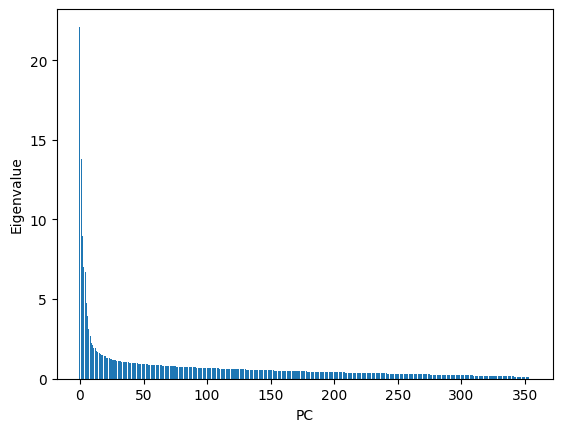

In [10]:
plt.bar(range(len(l)), l)
# plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('Eigenvalue')

## Plot the Density of States

Text(0.5, 0, 'Density Of States')

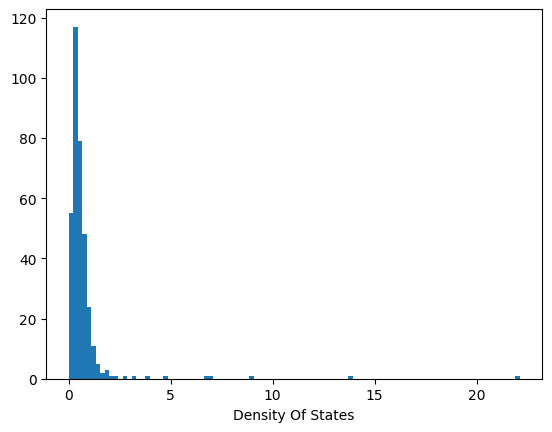

In [11]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

## Calculate the Eigenportfolio Returns

In [12]:
# F = pd.DataFrame(w_prime)
F = l2af.calculate_eigen_returns(w_prime, R)

## Calculate SPX weighted returns

In [13]:
R_market = l2af.get_market_returns(startdate, days=20*365)
print(R_market.shape)

[*********************100%%**********************]  1 of 1 completed

(5028,)


## Plot The Actual SPX weighted returns vs. the first Eigenportfolio

5.336107849606062


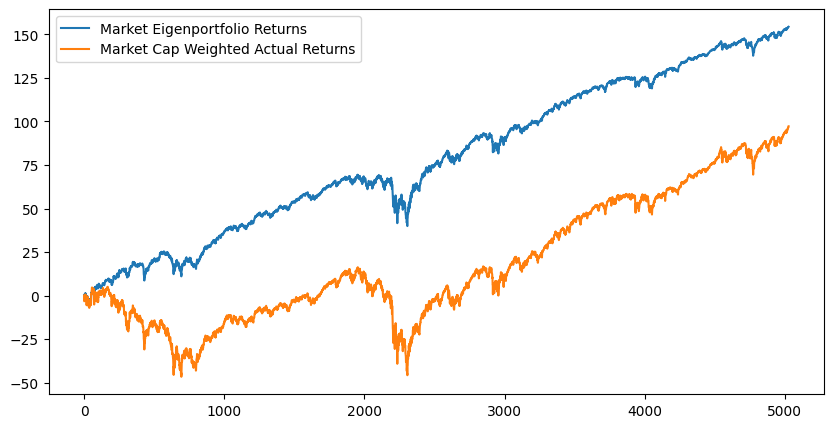

In [14]:
# RM = R.mean(axis=1)
print(max(np.abs(F[0].min()), np.abs(F[0].max())))
# data = F[0]/max(np.abs(F[0].min()), np.abs(F[0].max()))
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(F[0].cumsum(),  label="Market Eigenportfolio Returns")
ax.plot(R_market.cumsum(), label = "Market Cap Weighted Actual Returns")
plt.legend()

## Plot the first Eigenvector

Top 10 Stocks
    Symbol                Security  GICS Sector
57     BAC         Bank of America   Financials
121    CMA                Comerica   Financials
238    HST   Host Hotels & Resorts  Real Estate
270    JPM          JPMorgan Chase   Financials
275    KEY                 KeyCorp   Financials
298    MTB                M&T Bank   Financials
375    PNC  PNC Financial Services   Financials
453    TFC                  Truist   Financials
456    USB               U.S. Bank   Financials
488    WFC             Wells Fargo   Financials

Bottom 10 Stocks
    Symbol               Security       GICS Sector
84     CPB  Campbell Soup Company  Consumer Staples
124     ED    Consolidated Edison         Utilities
159    DUK            Duke Energy         Utilities
172    ETR                Entergy         Utilities
217    GIS          General Mills  Consumer Staples
336    NEM                Newmont         Materials
371    PCG       PG&E Corporation         Utilities
421     SO       Souther

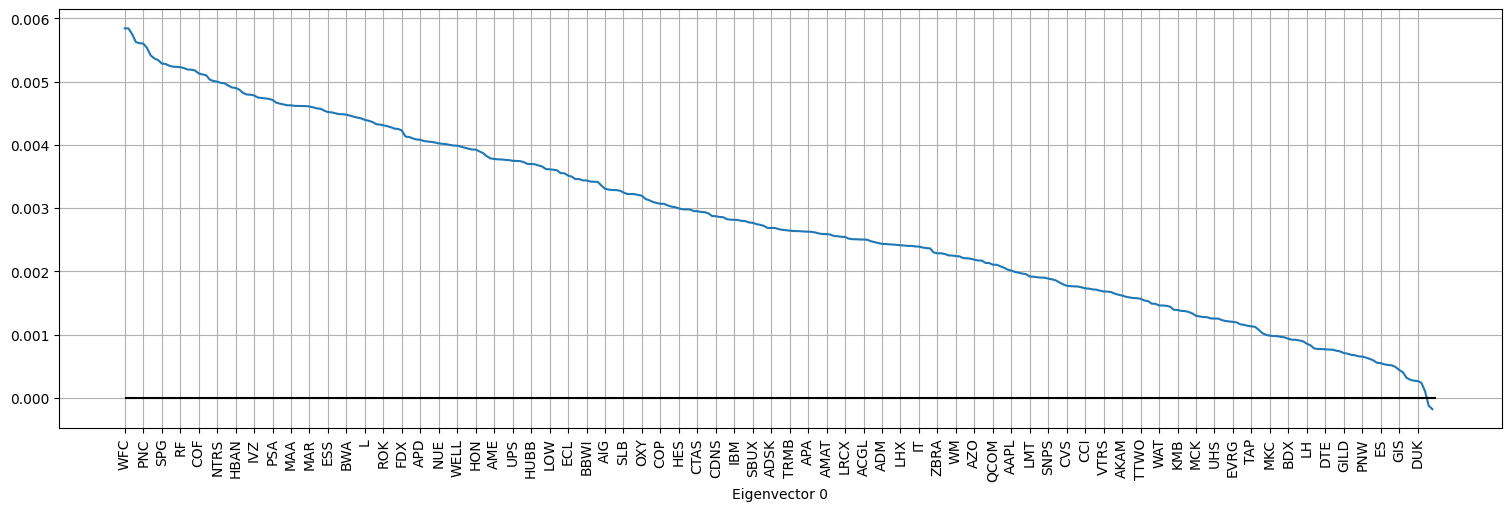

In [15]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 0)

## Plot Second Eigenvector

Top 10 Stocks
    Symbol                         Security GICS Sector
24     AEE                           Ameren   Utilities
124     ED              Consolidated Edison   Utilities
153      D                  Dominion Energy   Utilities
158    DTE                       DTE Energy   Utilities
172    ETR                          Entergy   Utilities
339    NEE                   NextEra Energy   Utilities
374    PNW                    Pinnacle West   Utilities
384    PEG  Public Service Enterprise Group   Utilities
421     SO                 Southern Company   Utilities
487    WEC                 WEC Energy Group   Utilities

Bottom 10 Stocks
    Symbol              Security             GICS Sector
35     ADI        Analog Devices  Information Technology
40    AMAT     Applied Materials  Information Technology
271   JNPR      Juniper Networks  Information Technology
280   KLAC       KLA Corporation  Information Technology
285   LRCX          Lam Research  Information Technology
317   MCHP

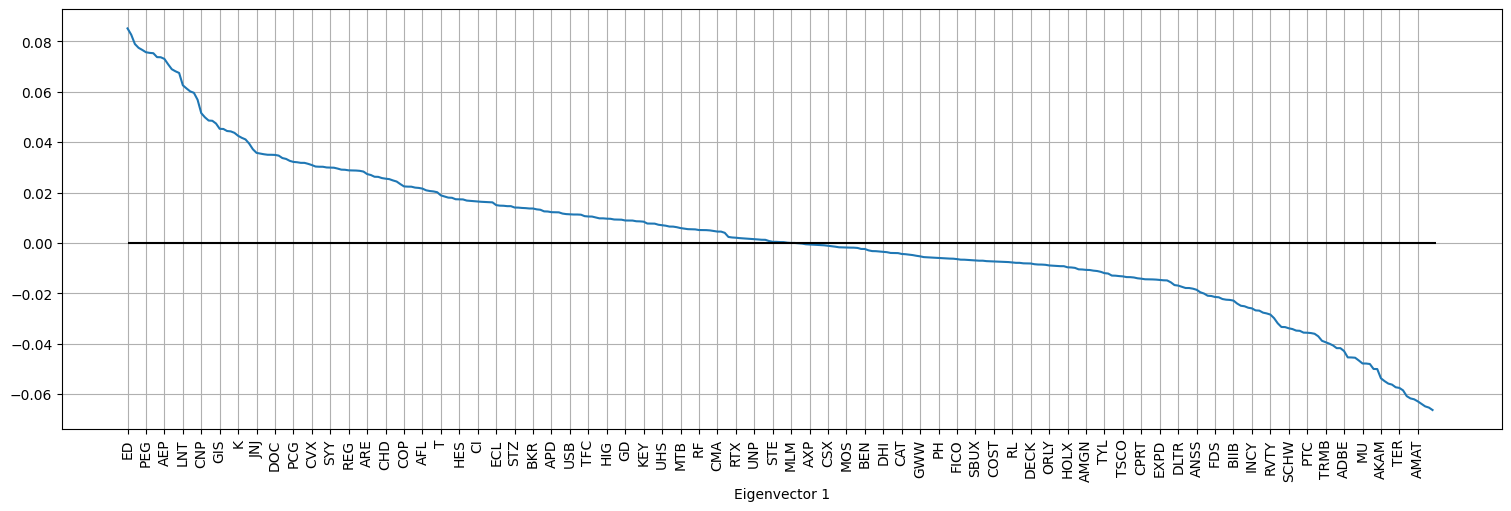

In [16]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 1)

## Plot Third Eigenvector

Top 10 Stocks
    Symbol              Security GICS Sector
38     APA       APA Corporation      Energy
104    CVX   Chevron Corporation      Energy
123    COP        ConocoPhillips      Energy
146    DVN          Devon Energy      Energy
173    EOG         EOG Resources      Energy
189    XOM            ExxonMobil      Energy
224    HAL           Halliburton      Energy
231    HES      Hess Corporation      Energy
299    MRO          Marathon Oil      Energy
353    OXY  Occidental Petroleum      Energy

Bottom 10 Stocks
    Symbol               Security  GICS Sector
52     AVB  AvalonBay Communities  Real Estate
72     BXP      Boston Properties  Real Estate
83     CPT  Camden Property Trust  Real Estate
178    EQR     Equity Residential  Real Estate
194    FRT         Federal Realty  Real Estate
278    KIM           Kimco Realty  Real Estate
386    PSA         Public Storage  Real Estate
396    REG        Regency Centers  Real Estate
416    SPG   Simon Property Group  Real Estate
458

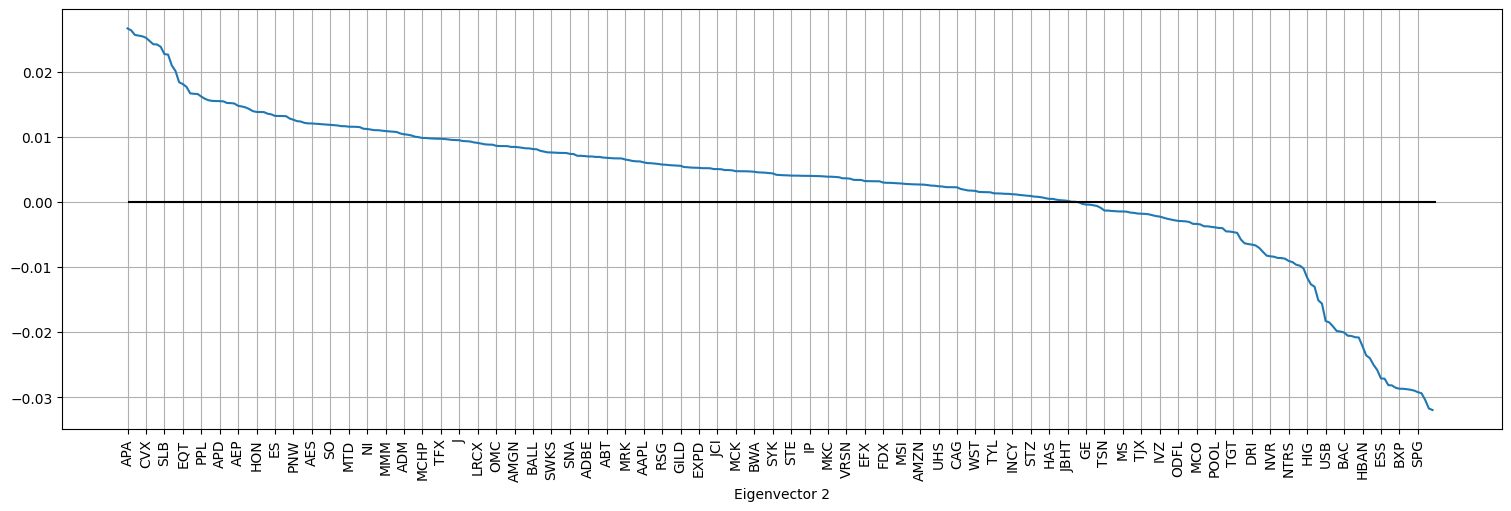

In [17]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 2)

## Advanced Goal 1
#### Repeat the PCA on data right after the data we used

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


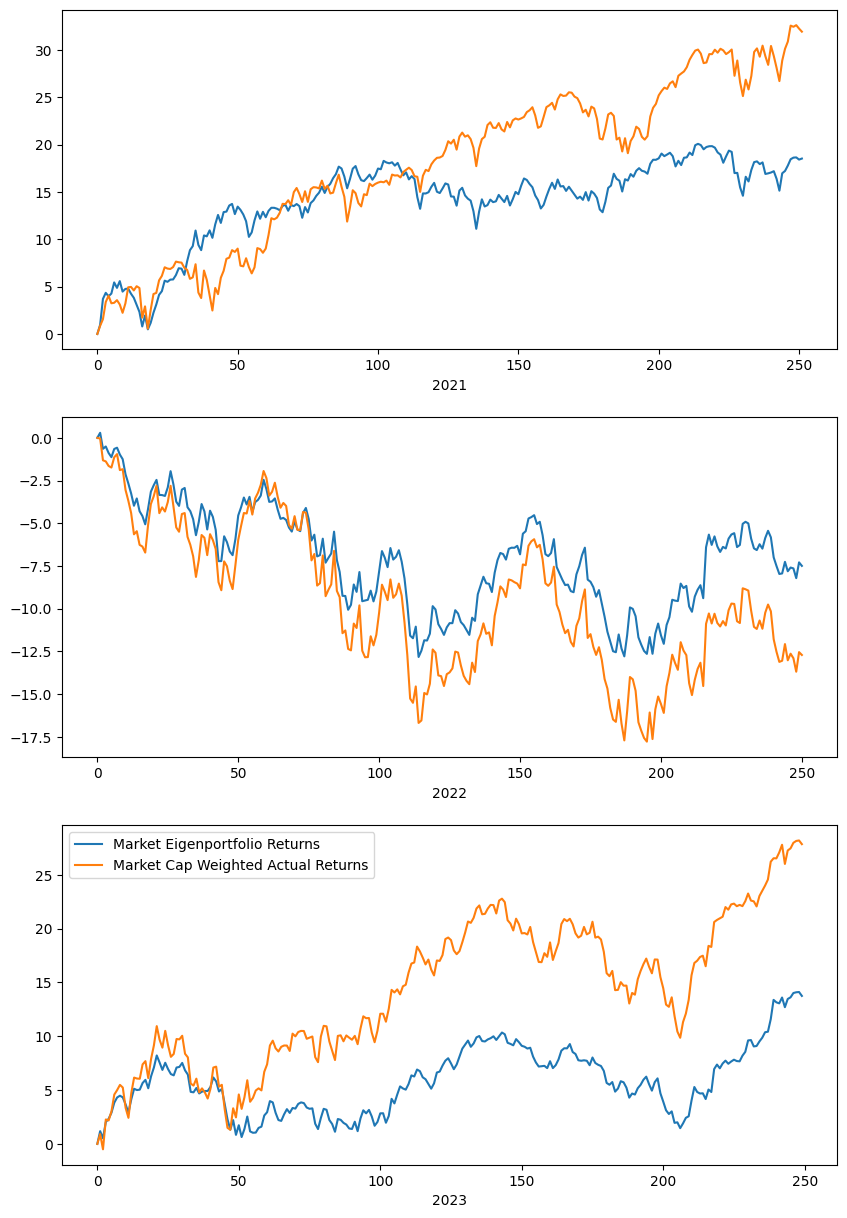

In [18]:
#Check fof 2020-2024
start = 2020
fig, ax = plt.subplots(3, figsize=(10,15))
for i in range(3):
    start += 1
    filename = f'spx_{start}_adj_close.csv'
    startdate = datetime.datetime(start,1,1)
    df_spx = l2af.load_data(tickers, startdate, filename, days=365, force=False)
    df_spx = l2af.clean_data(df_spx)
    R, Y = l2af.calculate_returns(df_spx)
    filename_corr = f'correlation_matrix_{start}.csv'
    p = l2af.consrtuct_correlation_matrix(Y, filename_corr, force=False)
    w_prime, variance_explained, l = l2af.calculate_pca(p)
    F = l2af.calculate_eigen_returns(w_prime, R)
    R_market = l2af.get_market_returns(startdate, days=365, )
    l2af.plot_returns(start, F, R_market, ax[i])
    # plot_eigen_returns(F, ax[i][1])
plt.legend()

## Advanced Goal 2
#### Check if the Eigenportfolio returns are uncorrelated:

### Visual Inspection of returns for the 1st 5 eigenportfolios

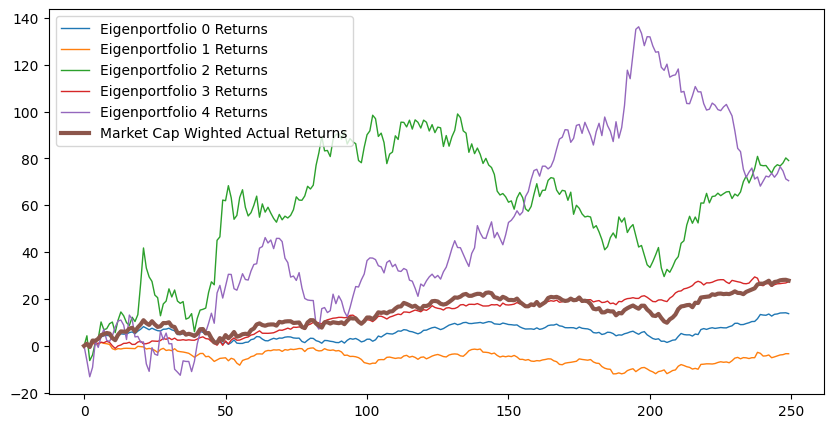

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for i in range(5):
    ax.plot(F[i].cumsum(), linewidth=1, label=f"Eigenportfolio {i} Returns")
ax.plot(R_market.cumsum(), linewidth=3, label = "Market Cap Wighted Actual Returns")
plt.legend()

## Do Hypothesis Testing<br>
Null Hypothesis (H₀): The datasets are not correlated (correlation coefficient = 0).<br>
Alternative Hypothesis (H₁): The datasets are correlated (correlation coefficient ≠ 0).

In [20]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from itertools import combinations

alpha = 0.05
p_values = {}

comb = combinations(range(len(F)), 2)
for ctr, i in enumerate(comb):
        # Pearson Correlation
        pearson_corr, pearson_p_value = pearsonr(F[i[0]].to_numpy(), F[i[1]].to_numpy())
        p_values[f'{i[0]}-{i[1]}'] = pearson_p_value 
        if ctr % 100 == 0:
            print(f'\nFor Eigenportfolio {i[0]} and {i[1]}:')
            # Interpretation
            if pearson_p_value > alpha:
                print("Pearson correlation: No significant correlation")
            else:
                print("Pearson correlation: Significant correlation")





For Eigenportfolio 0 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 101:
Pearson correlation: No significant correlation

For Eigenportfolio 0 and 201:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 53:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 153:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 6:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 106:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 206:
Pearson correlation: No significant correlation

For Eigenportfolio 3 and 60:
Pearson correlation: No significant correlation

For Eigenportfolio 3 and 160:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 15:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 115:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 215:
Pearson correlation: No signifi

## Do Holm's Step-Down Procedure

In [21]:
df_stat=pd.DataFrame()
df_stat['Eigenportfolio pair']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
# Reject Null Hypothesis = Correlated
df_stat['correlated'] = df_stat['p_value'] < df_stat['L_thresholds']
df_stat.reset_index(drop=True, inplace=True)
print(df_stat)
correlated = max(df_stat.loc[df_stat['correlated'] == True].index +1)
not_correlated = len(df_stat.index) - correlated
print(f'\nNot Correlated: {not_correlated/(correlated+not_correlated) * 100}%')

      Eigenportfolio pair       p_value  L_thresholds  correlated
0                 248-249  4.686736e-51      0.000002        True
1                     0-1  9.522562e-20      0.000002        True
2                     0-3  1.104736e-13      0.000002        True
3                     1-3  3.385097e-11      0.000002        True
4                     0-5  2.858851e-09      0.000002        True
...                   ...           ...           ...         ...
31120              14-133  9.999966e-01      0.010000       False
31121              59-239  9.999969e-01      0.012500       False
31122             133-192  9.999971e-01      0.016667       False
31123              59-133  9.999974e-01      0.025000       False
31124             133-239  9.999991e-01      0.050000       False

[31125 rows x 4 columns]

Not Correlated: 99.97751004016064%


#### 99.97% Of Eigenportfolios show no statistically significant correlation on returns.

## Advanced Goal 3
#### Perform MPT and check where the Eigenportfolios are relative to the efficient frontier

In [479]:
import mpt
importlib.reload(mpt)

<module 'mpt' from '/home/andy/Work/AIM/Subjects/Term 2/Data Mining And Wrangling/Lab2A/mpt.py'>

Generate MPT plot using random weights, using a random sampling of 3 stocks from the portfolio

In [480]:
indices = np.random.choice(range(len(R.columns)), size=3, replace=False)
R_sample=R[R.columns[indices]]
mpt_random = mpt.MPT(R_sample)
print(mpt_random.mpt_results)

(250, 3)
            0         1         2  Expected Returns  Portfolio Variance
0    0.376576  0.423650  0.199774          0.000531            0.000121
1    0.507198  0.152458  0.340344          0.000669            0.000152
2    0.366643  0.362743  0.270615          0.000527            0.000120
3    0.453963  0.372833  0.173204          0.000604            0.000133
4    0.412344  0.283996  0.303660          0.000574            0.000129
..        ...       ...       ...               ...                 ...
295  0.277583  0.372958  0.349459          0.000447            0.000114
296  0.397843  0.009070  0.593087          0.000582            0.000174
297  0.244268  0.380144  0.375588          0.000416            0.000114
298  0.290133  0.301477  0.408390          0.000463            0.000122
299  0.414608  0.140601  0.444791          0.000587            0.000146

[300 rows x 5 columns]


In [484]:
mpt_eig = mpt.MPT(R_sample, weights=w_prime[:,indices])
print(mpt_eig.mpt_results)


(250, 3)
            0         1         2  Expected Returns  Portfolio Variance
0    0.299469  0.298480  0.402051          0.000472            0.000122
1    0.321827  0.350161  0.328011          0.000488            0.000118
2    0.363794  0.349815  0.286391          0.000525            0.000121
3    0.357278  0.426930  0.215792          0.000514            0.000118
4    0.315466  0.396707  0.287827          0.000479            0.000115
..        ...       ...       ...               ...                 ...
492  0.947754  0.000000  0.052246          0.001073            0.000301
493  0.661752  0.000000  0.338248          0.000818            0.000197
494  0.544764  0.455236  0.000000          0.000679            0.000162
495  0.629230  0.000000  0.370770          0.000789            0.000191
496  0.000000  0.997389  0.002611          0.000151            0.000141

[497 rows x 5 columns]


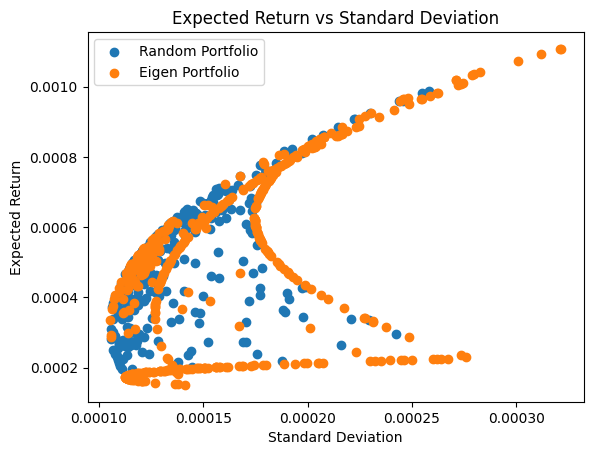

In [485]:
fig, ax = plt.subplots(1, 1)
ax.scatter(mpt_random.mpt_results['Portfolio Variance'],mpt_random.mpt_results['Expected Returns'], label="Random Portfolio")
ax.scatter( mpt_eig.mpt_results['Portfolio Variance'],mpt_eig.mpt_results['Expected Returns'], label="Eigen Portfolio")

ax.set_title('Expected Return vs Standard Deviation')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
plt.legend()